In [1]:
import keras

import numpy as np

import matplotlib.pyplot as plt

import sklearn.decomposition
import sklearn.neighbors
import sklearn.manifold

import random

import time

import numba

Using TensorFlow backend.


In [2]:
REGULAR_EPOCHS = 80
REGULAR_BATCH_SIZE = 128
PRETRAIN_EPOCHS = 50

<a id="segundo"></a>
## 2. Autoencoders (AEs) en MNIST


Como se ha discutido en clases, las RBM’s y posteriormente los AE’s (redes no supervisadas) fueron un componente crucial en el desarrollo de los modelos que entre 2006 y 2010 vigorizaron el área de las redes neuronales artificiales con logros notables de desempeño en diferentes tareas de aprendizaje automático. En esta sección aprenderemos a utilizar el más sencillo de estos modelos: un autoencoder o AE. Consideraremos tres aplicaciones clásicas: reducción de dimensionalidad, *denoising* y pre-entrenamiento. Con este objetivo en mente, utilizaremos un dataset denominado MNIST[[3]](#refs). Se trata de una colección de 70000 imágenes de 28 $\times$ 28 pixeles correspondientes a dígitos manuscritos (números entre 0 y 9). En su versión tradicional, la colección se encuentra separada en dos subconjuntos: uno de entrenamiento de 60000 imágenes y otro de test de 10000 imágenes. La tarea consiste en construir un programa para que aprenda a identificar correctamente el dı́gito representado en la imagen

---

a) Escriba el código que **cargue los datos** desde el repositorio de keras, normalice las imágenes de modo que los pixeles queden en [0, 1], transforme las imágenes en vectores ($\in {\rm I\!R}^{784}$) y devuelva tres subconjuntos disjuntos: uno de entrenamiento, uno de validación y uno de pruebas. Construya el conjunto de validación de la manera que estime conveniente, éste debe contar con $nval = 5000$ imágenes.

In [3]:
(x_training, y_training), (x_test, y_test) = keras.datasets.mnist.load_data()
x_training = x_training.astype('float32')/255.
x_test  = x_test.astype('float32') /255.

# Shuffle train data:
n_vali = 5000
indexes = np.arange(x_training.shape[0])
np.random.shuffle(indexes)

x_val = x_training[indexes[:n_vali]]
y_val = y_training[indexes[:n_vali]]
x_tra = x_training[indexes[n_vali:]]
y_tra = y_training[indexes[n_vali:]]

print("x_val.shape",x_val.shape)
print("y_val.shape",y_val.shape)
print("x_tra.shape",x_tra.shape)
print("y_tra.shape",y_tra.shape)
print("x_test.shape",x_test.shape)
print("y_test.shape",y_test.shape)

x_val.shape (5000, 28, 28)
y_val.shape (5000,)
x_tra.shape (55000, 28, 28)
y_tra.shape (55000,)
x_test.shape (10000, 28, 28)
y_test.shape (10000,)


---

### 2.1 Reducción de dimensionalidad
Para esta primera sección, gracias a la simplicidad del problema tratado, se experimentará con un autoencoder tradicional (*feed forward*) en donde las capas de éste sean densas. Para esto se re estructurarán los datos de entradas en forma de vector, es decir la matriz de 28 $\times$ 28 pasa a ser un vector de 784 componentes.

In [4]:
x_tra_f = x_tra.reshape((len(x_tra),np.prod(x_tra.shape[1:])))
x_val_f = x_val.reshape((len(x_val),np.prod(x_val.shape[1:])))
x_test_f = x_test.reshape((len(x_test),np.prod(x_test.shape[1:])))

print("x_tra_f.shape",x_tra_f.shape)
print("x_val_f.shape",x_val_f.shape)
print("x_test_f.shape",x_test_f.shape)

x_tra_f.shape (55000, 784)
x_val_f.shape (5000, 784)
x_test_f.shape (10000, 784)


Una de las aplicaciones tı́picas de un AE es reducción de dimensionalidad, es decir, implementar una transformación $\phi:{\rm I\!R}^d \rightarrow {\rm I\!R}^{d'}$ de objetos representados originalmente por $d$ atributos en una nueva representación de $d'$ atributos, de modo tal que se preserve lo mejor posible la “información” original. Obtener tal representación es útil desde un punto de vista computacional (compresión) y estadı́stico (permite construir modelos con un menor número de parámetros libres). Un AE es una técnica de reducción de dimensionalidad no supervisada porque no hace uso de información acerca de las clases a las que pertenecen los datos de entrenamiento.  

---

a) Entrene un AE básico (1 capa escondida) para generar una representación de MNIST en $d'$= 2, 8, 32, 64 dimensiones. **Justifique la elección de la función de pérdida a utilizar y del criterio de entrenamiento en general**. Determine el porcentaje de compresión obtenido y el error de reconstrucción en cada caso. **¿Mejora el resultado si elegimos una función de activación *ReLU* para el *Encoder*? ¿Podrı́a y/o corresponde utilizar ésta activación en el *Decoder*?**

In [5]:
def autoencoder(dims,activ):
    # Layers
    input_img = keras.layers.Input(shape=(784,))
    encoded = keras.layers.Dense(dims, activation=activ)(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid')(encoded)
    # Whole Autoencoder
    autoencoder = keras.models.Model(inputs=input_img,outputs=decoded)
    # Encoder
    encoder = keras.models.Model(inputs=input_img,outputs=encoded)
    # Decoder
    encoded_input = keras.layers.Input(shape=(dims,))
    decoder_layer = autoencoder.layers[-1]
    decoder = keras.models.Model(inputs=encoded_input,outputs=decoder_layer(encoded_input))
    # Return the 3 models
    return autoencoder,encoder,decoder

In [6]:
DIMS = (2,8,32,64)

In [ ]:
# ---@> Train models:
for dim in DIMS:
    for activ in ('sigmoid','relu'):
        model_ae,model_e,model_d = autoencoder(dim,activ)
        model_ae.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        model_ae.fit(x_tra_f,x_tra_f,epochs=REGULAR_EPOCHS,batch_size=REGULAR_BATCH_SIZE,
                     validation_data=(x_val_f,x_val_f))
        model_e.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        model_d.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        model_e.save("basic_e_%d_%s.h5"%(dim,activ))
        model_d.save("basic_d_%d_%s.h5"%(dim,activ))
        model_ae.save("basic_ae_%d_%s.h5"%(dim,activ))

In [8]:
tra_recerr = {}
test_recerr = {}
# Get errors
for dim in DIMS:
    for activ in ('sigmoid','relu'):
        name = "basic_ae_%d_%s.h5"%(dim,activ)
        ae = keras.models.load_model(name)
        x_pred_tra_f = ae.predict(x_tra_f,batch_size=REGULAR_BATCH_SIZE)
        x_pred_test_f = ae.predict(x_test_f,batch_size=REGULAR_BATCH_SIZE)
        error_tra = np.mean((x_pred_tra_f-x_tra_f)**2)
        error_test = np.mean((x_pred_test_f-x_test_f)**2)
        print("%-30s  tr_err:%.7f  te_err:%.7f"%(name,error_tra,error_test))
        tra_recerr[name] = error_tra
        test_recerr[name] = error_test

basic_ae_2_sigmoid.h5           tr_err:0.0868354  te_err:0.0870441
basic_ae_2_relu.h5              tr_err:0.0634873  te_err:0.0633909
basic_ae_8_sigmoid.h5           tr_err:0.0721742  te_err:0.0723997
basic_ae_8_relu.h5              tr_err:0.0529457  te_err:0.0525006
basic_ae_32_sigmoid.h5          tr_err:0.0684123  te_err:0.0685954
basic_ae_32_relu.h5             tr_err:0.0410560  te_err:0.0405410
basic_ae_64_sigmoid.h5          tr_err:0.0679016  te_err:0.0680649
basic_ae_64_relu.h5             tr_err:0.0372701  te_err:0.0367942


> Se utilizó el *mse* como función de pérdida pues penaliza menos los errores graves, a diferencia de la *binary_crossentropy* que podría empujar los valores entregados por la red a promedios (penaliza $\infty$ una predicción completamente errónea). Como *mse* las permitiría, se esperaría que obtenga imágenes menos centradas en el promedio. Además, como la data de MNIST no es binaria, es imposible obtener pérdida 0 con *binary_crossentropy* ya que también está sumada la entropía de la fuente.

> Puesto que sólo se deben guardar $d$ floats, en vez de 784 bytes, el radio de compresión es de
$$
\frac{4 \cdot d}{784} \approx 0.0051 d
$$
sin embargo, esta es una compresión con pérdida.

> ReLU obtiene mejores resultados independiente del número de dimensiones, esto puede deberse a que esta activación permite crear cortes abruptos en la función resultante (a manera de IFs) lo que permitiría replicar mejor estructuras que están presentes sólo ante la presencia de otras y separar los casos para las diversas clases de dígitos. Además de esto, ReLU tiene un dominio mayor que $[0,1]$.

> En el decoder no corresponde usar esta activación pues permitiría píxeles con valores superiores a 1 (en el caso de que se hubiera usado *binary_crossentropy* esto no tendría sentido).

---

b) Compare visualmente la reconstrucción que logra hacer el *autoencoder* desde la representación en ${\rm I\!R}^{d'}$ para algunas imágenes del conjunto de pruebas. **Determine si la percepción visual se corresponde con el error de reconstrucción observada**. Comente.

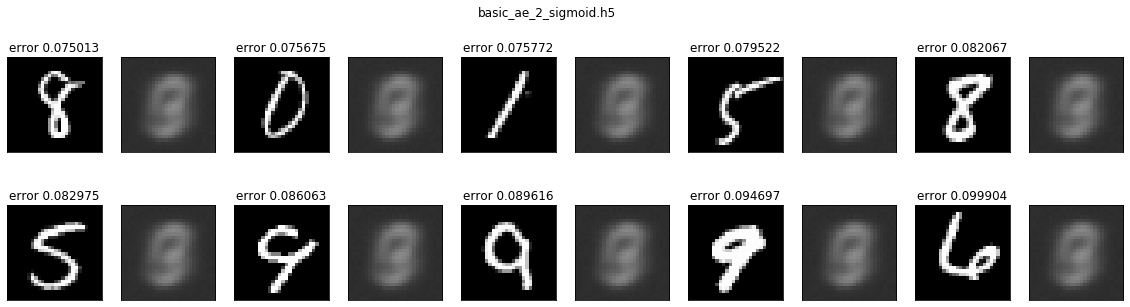

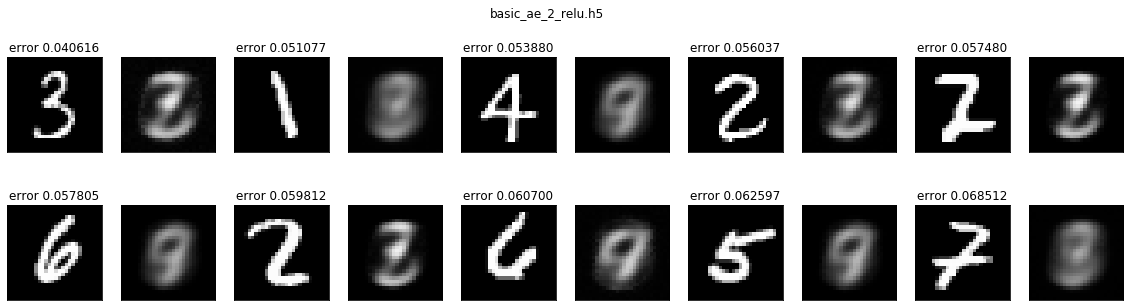

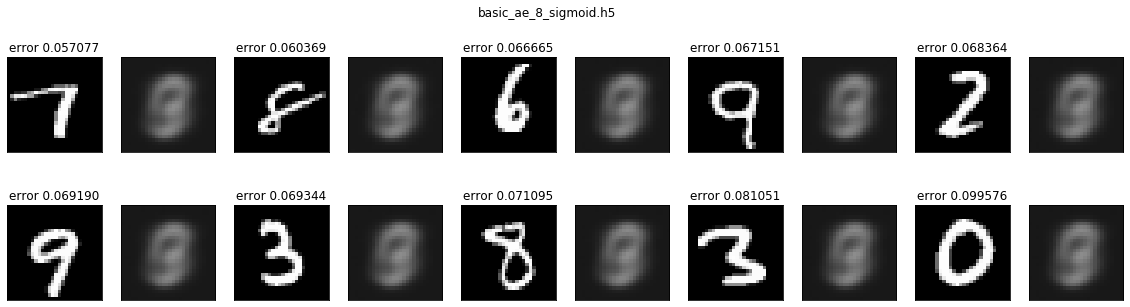

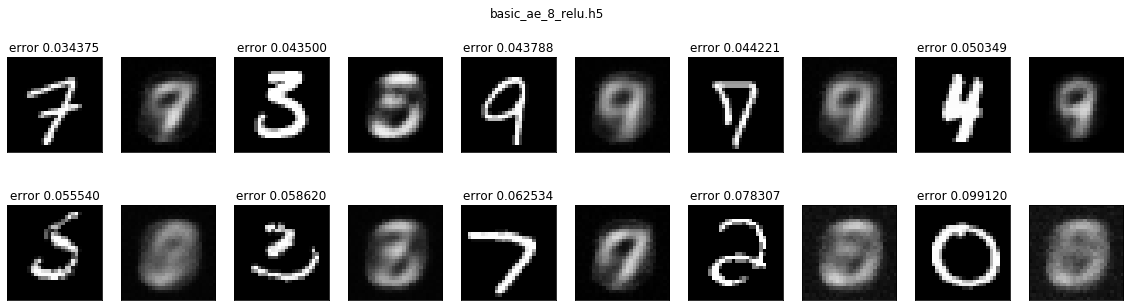

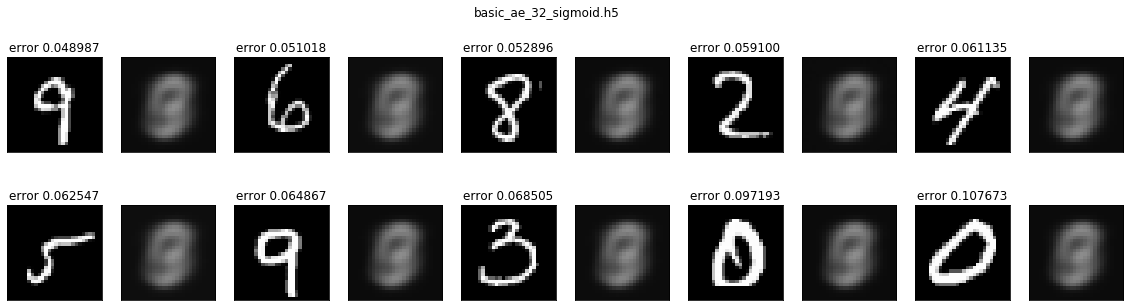

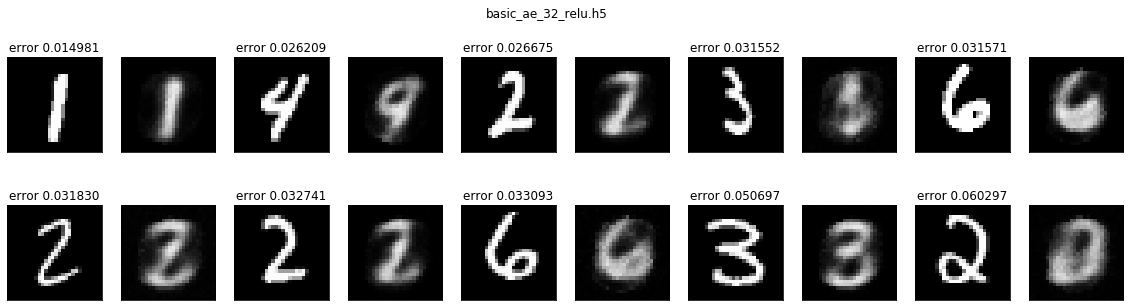

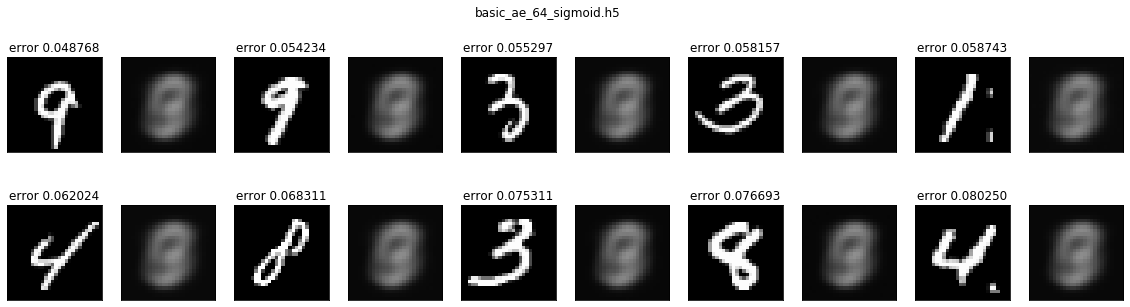

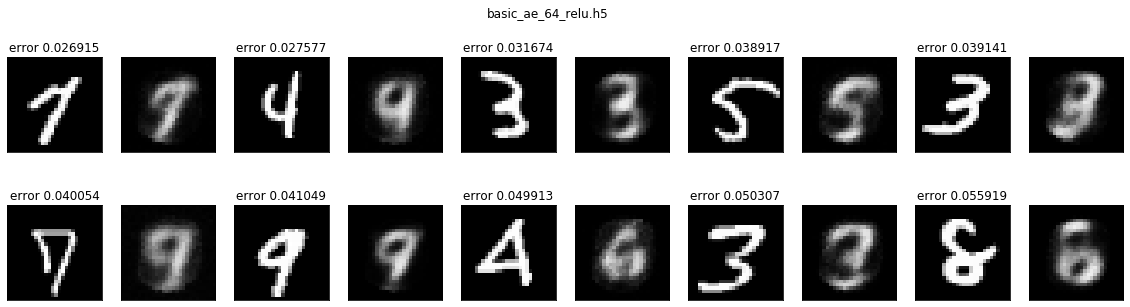

In [9]:
# Get errors
for dim in DIMS:
    for activ in ('sigmoid','relu'):
        name = "basic_ae_%d_%s.h5"%(dim,activ)
        ae = keras.models.load_model(name)
        idxs = np.arange(x_test_f.shape[0])
        np.random.shuffle(idxs)
        N = 10
        idxs = idxs[:N]
        reals = x_test_f[idxs]
        preds = ae.predict(reals)
        errors = np.mean((reals-preds)**2,axis=1)
        # Sort in increasing error
        trf = np.argsort(errors)
        reals = reals[trf]
        preds = preds[trf]
        errors = errors[trf]
        #
        plt.figure(figsize=(2*N,5))
        plt.suptitle(name)
        for i in range(N):
            ax = plt.subplot(2,N,2*i+1)
            ax.set_title("error %f"%errors[i])
            ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
            plt.imshow(reals[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
            ax = plt.subplot(2,N,2*i+2)
            ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
            plt.imshow(preds[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
        plt.show()

> Se seleccionaro muestras aleatorias para cada autoencoder y se ordenaron de menor a mayor error. Se puede ver, sobretodo en los AE con más dimensiones, que el error se corresponde con la calidad de la reconstrucción.

> La activación *ReLU* permitió obtener reconstrucciones menos borrosas, mientras que *sigmoid* entregó principalmente promedios.


---

c) Para verificar la calidad de la representación obtenida, implemente el clasificador denominado $kNN$ (k-nearest neighbor): dada una imagen $x$, el clasificador busca las k = 10 imágenes de entrenamiento más similares (de acuerdo a una distancia, e.g. euclidiana) y predice como clase, la etiqueta más popular entre las imágenes cercanas. **Mida el error de pruebas** obtenido construyendo este clasificador sobre la data reducida a través del *autoencoder* comparando con la representación reducida obtenida vía PCA (una técnica clásica de reducción de dimensionalidad) utilizando el mismo número de dimensiones $d'$= 2, 4, 8, 16, 32. Considere tanto el error de reconstrucción como el desempeño en clasificación , además de comparar los tiempos medios de predicción en ambos escenarios **¿La representación generada por el *autoencoder* logra generalizar?**

In [10]:
# Get errors
for dim in DIMS:
    # PCA
    pca = sklearn.decomposition.PCA(n_components=dim)
    pca.fit(x_tra_f)
    pca_train = pca.transform(x_tra_f)
    #
    clf = sklearn.neighbors.KNeighborsClassifier(10)
    clf.fit(pca_train,y_tra)
    #
    start = time.time()
    pca_test = pca.transform(x_test_f)
    score = clf.score(pca_test,y_test)
    elapsed = time.time()-start
    #
    print('%3ddims %-15s  score:%.3f   time:%8.3f[s]'%(
        dim,'pca',score,elapsed))
    #
    for activ in ('sigmoid','relu'):
        # AUTOENCODER
        nameae = "basic_ae_%d_%s.h5"%(dim,activ)
        name = "basic_e_%d_%s.h5"%(dim,activ)
        enc = keras.models.load_model(name)
        enc_train = enc.predict(x_tra_f)
        clf = sklearn.neighbors.KNeighborsClassifier(10)
        clf.fit(enc_train,y_tra)
        #
        start = time.time()
        enc_test = enc.predict(x_test_f)
        score = clf.score(enc_test,y_test)
        elapsed = time.time()-start
        #
        print('%3ddims %-15s  score:%.3f   time:%8.3f[s]  recons_tra:%.3f  recons_test:%.3f'%(
        dim,'ae_'+activ,score,elapsed,tra_recerr[nameae],test_recerr[nameae]))

  2dims pca              score:0.439   time:   0.064[s]
  2dims ae_sigmoid       score:0.210   time:   0.241[s]  recons_tra:0.087  recons_test:0.087
  2dims ae_relu          score:0.324   time:   0.200[s]  recons_tra:0.063  recons_test:0.063
  8dims pca              score:0.903   time:   1.060[s]
  8dims ae_sigmoid       score:0.465   time:   1.000[s]  recons_tra:0.072  recons_test:0.072
  8dims ae_relu          score:0.811   time:   0.650[s]  recons_tra:0.053  recons_test:0.053
 32dims pca              score:0.973   time:  23.786[s]
 32dims ae_sigmoid       score:0.799   time:  14.135[s]  recons_tra:0.068  recons_test:0.069
 32dims ae_relu          score:0.928   time:   7.755[s]  recons_tra:0.041  recons_test:0.041
 64dims pca              score:0.973   time:  52.108[s]
 64dims ae_sigmoid       score:0.874   time:  23.090[s]  recons_tra:0.068  recons_test:0.068
 64dims ae_relu          score:0.944   time:  20.590[s]  recons_tra:0.037  recons_test:0.037


 > Se puede ver que aunque los AE no logran mejores resultados en el conjunto de prueba que PCA, los con activación *ReLU* se mantienen cerca. Se puede ver que el error de reconstrucción de *testing* es bastante cercano al error de reconstrucción de *training*, esto en conjunto con la buena *accuracy* implican que los AE con activación *ReLU* generalizan correctamente. No es tan así para los AE con activación *sigmoid*.

---

d) Modifique el *autoencoder* básico construido en (a) para implementar un deep autoencoder (*deep AE*), es decir, un autoencoder con al menos dos capas ocultas. **Demuestre experimentalmente** que este *autoencoder* puede mejorar la compresión obtenida por PCA utilizando el mismo número de dimensiones $d'$ . Experimente con $d'$ =2, 4, 8, 16 y distintas profundidades ($L \in [2,4]$). Considere en esta comparación tanto el error de reconstrucción como el desempeño en clasificación (vı́a kNN) de cada representación. Comente.

In [11]:
def deep_autoencoder(dims,nneurons=(1000,500,250)):
    # Layers
    input_img = keras.layers.Input(shape=(784,))
    enc_layers = [keras.layers.Dense(x,activation='relu') for x in nneurons]
    enc_layers.append(keras.layers.Dense(dims,activation='relu'))
    dec_layers = [keras.layers.Dense(x,activation='relu') for x in nneurons[::-1]]
    dec_layers.append(keras.layers.Dense(784,activation='sigmoid'))
    # Encoding
    front = input_img
    for la in enc_layers:
        front = la(front)
    encoder = front
    # Decoding
    for la in dec_layers:
        front = la(front)
    # Whole Autoencoder
    autoenc = keras.models.Model(inputs=input_img,outputs=front)
    # Encoder
    encoder = keras.models.Model(inputs=input_img,outputs=encoder)
    # Decoder
    encoded_input = keras.layers.Input(shape=(dims,))
    front = encoded_input
    for la in dec_layers:
        front = la(front)
    decoder = keras.models.Model(inputs=encoded_input,outputs=front)
    # Return the 3 models
    return autoenc,encoder,decoder

In [12]:
ARCHS = {'2la':[500,250],'4la':[1000,750,500,250]}
DIMS2 = [2,4,8,16]

In [ ]:
# ---@> Train models:
for dim in DIMS2:
    for idc in ARCHS:
        neurons= ARCHS[idc]
        name = "deep_%s_ae_%d.h5"%(idc,dim)
        ename = "deep_%s_e_%d.h5"%(idc,dim)
        dname = "deep_%s_d_%d.h5"%(idc,dim)
        model_ae,model_e,model_d = deep_autoencoder(dim,neurons)
        model_ae.compile(optimizer=keras.optimizers.SGD(lr=1.0),loss='mse')
        model_ae.fit(x_tra_f,x_tra_f,epochs=REGULAR_EPOCHS,batch_size=REGULAR_BATCH_SIZE)
        model_ae.save(name)
        #
        model_e.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        model_d.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        model_e.save(ename)
        model_d.save(dname)

In [14]:
for dim in DIMS2:
    # PCA
    pca = sklearn.decomposition.PCA(n_components=dim)
    pca.fit(x_tra_f)
    pca_tra = pca.transform(x_tra_f)
    pca_test = pca.transform(x_test_f)
    clf = sklearn.neighbors.KNeighborsClassifier(10)
    clf.fit(pca_tra,y_tra)
    score = clf.score(pca_test,y_test)
    #
    print("%2ddims %-30s  score:%.3f"%(dim,'pca',score))
    #
    for idc in sorted(list(ARCHS)):
        name = "deep_%s_ae_%d.h5"%(idc,dim)
        ename = "deep_%s_e_%d.h5"%(idc,dim)
        autoenc = keras.models.load_model(name)
        encoder = keras.models.load_model(ename)
        # Reconstruction error
        x_test_pred_f = autoenc.predict(x_test_f,batch_size=REGULAR_BATCH_SIZE)
        recon_error = np.mean(np.mean((x_test_pred_f-x_test_f)**2,axis=1))
        # Clasification error:
        x_tra_enc = encoder.predict(x_tra_f,batch_size=REGULAR_BATCH_SIZE)
        x_test_enc = encoder.predict(x_test_f,batch_size=REGULAR_BATCH_SIZE)
        clf = sklearn.neighbors.KNeighborsClassifier(10)
        clf.fit(x_tra_enc,y_tra)
        score = clf.score(x_test_enc,y_test)
        print("%2ddims %-30s  score:%.3f  recons:%.3f"%(dim,name,score,recon_error))

 2dims pca                             score:0.436
 2dims deep_2la_ae_2.h5                score:0.639  recons:0.046
 2dims deep_4la_ae_2.h5                score:0.787  recons:0.039
 4dims pca                             score:0.645
 4dims deep_2la_ae_4.h5                score:0.816  recons:0.033
 4dims deep_4la_ae_4.h5                score:0.841  recons:0.033
 8dims pca                             score:0.903
 8dims deep_2la_ae_8.h5                score:0.898  recons:0.025
 8dims deep_4la_ae_8.h5                score:0.940  recons:0.018
16dims pca                             score:0.961
16dims deep_2la_ae_16.h5               score:0.959  recons:0.014
16dims deep_4la_ae_16.h5               score:0.963  recons:0.013


> Se puede ver que, al menos para la arquitectura de 4 capas ocultas, el score de los AE con activaciones **ReLU** logran una mejor accuracy para cualquier número de dimensiones, por lo tanto, obtienen mejores representaciones, pues son capaces de considerar features más complejas. Esto no se cumple para los AE con 2 capas ocultas en los casos de 8 y 16 dimensiones, y se cumple en menor grado para 2 y 4 dimensiones, esto se ve relacionado con un error de reconstrucción mayor.   

---

e) Elija algunas de las representaciones aprendidas anteriormente ($d>2$) y visualı́celas usando la herramienta *TSNE* disponible en la librerı́a *sklearn*. **Compare cualitativamente el resultado con aquel obtenido usando PCA** con el mismo número de componentes ($d>2$). Finalmente **grafique una representación** generada por un autoencoder directamente ($d=2$), comente.

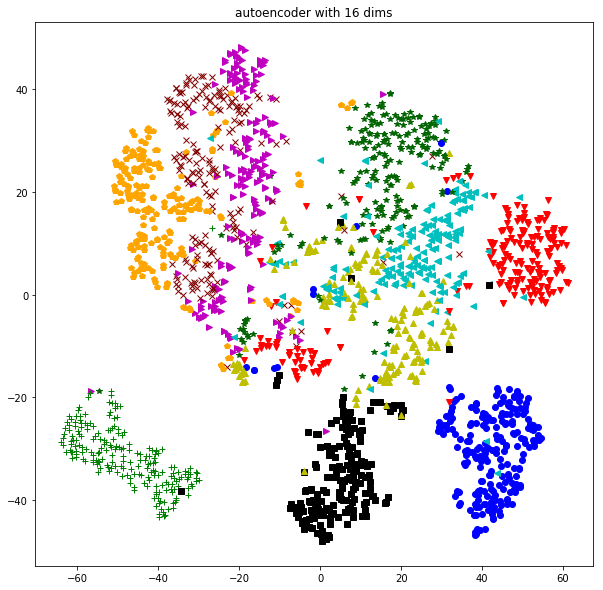

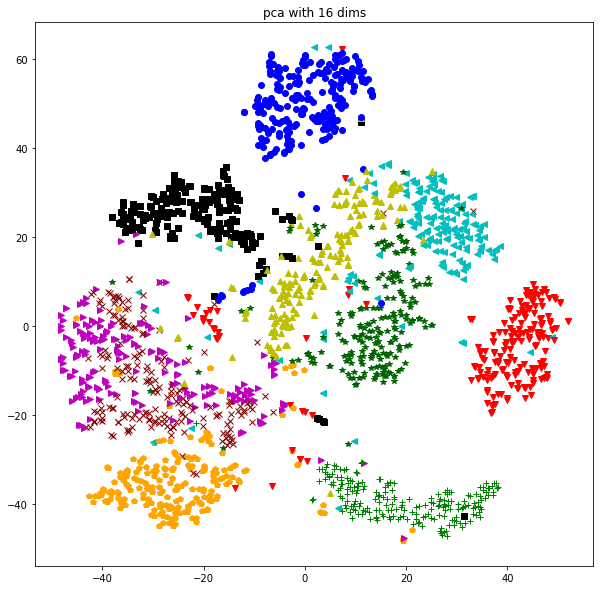

In [15]:
dims = 16
encoder = keras.models.load_model("deep_2la_e_%d.h5"%dims)

nplot = 2000
for t in (0,1):
    if t==0:
        enc_tra = encoder.predict(x_tra_f[:nplot])
    else:
        pca = sklearn.decomposition.PCA(n_components=dim)
        pca.fit(x_tra_f)
        pca_train = pca.transform(x_tra_f)
        enc_tra = pca_train[:nplot]
    #
    model = sklearn.manifold.TSNE(n_components=2,random_state=0)
    enc_tra = model.fit_transform(enc_tra)

    # Plot with tnse:
    plt.figure(figsize=(10,10))
    plt.title(("autoencoder" if t==0 else "pca")+" with %d dims"%dims)
    colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
    markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
    for idx in range(nplot):
        label = y_tra[idx]
        line = plt.plot(enc_tra[idx][0],enc_tra[idx][1],
            color=colors[label], marker=markers[label], markersize=6)
    plt.show()

> En ambos casos se puede ver que las clases están bien separadas salvo por outliers que salen de la sección. Se puede ver que PCA tiene un par de clases (9 y 4) bastante superpuestas en esta representacióny una mayor cantidad de muestras fuera de su clúster, por lo que se puede deducir que la representación AE es mejor para extraer características que sirven para clasificar números, pese a no haber sido entrenada para este propósito.

---

f) Cuando el problema se torna más difícil es necesario complejizar el modelo. Modifique el autoencoder construido en (a) para trabajar directamente sobre las imágenes de MNIST, sin tratarlas como vectores de 784 atributos, sino como matrices de tamaño $1\times28\times28$. Es posible lograr este objetivo utilizando capas convolucionales para definir el *Encoder* y capas con **convoluciones transpuesta** en el *Decoder*, comente como sufre las transformaciones el patrón de entrada. Compare la calidad de la representación reducida obtenida por el nuevo autoencoder con aquella obtenida anteriormente utilizando el mismo número de dimensiones. Comente.

In [16]:
def conv_autoencoder(dims):
    input_img = keras.layers.Input(shape=(28,28,1))
    front = input_img
    front = keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(front)
    front = keras.layers.MaxPooling2D((2,2))(front)
    front = keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(front)
    front = keras.layers.MaxPooling2D((2,2))(front)
    front = keras.layers.Flatten()(front)
    front = keras.layers.Dense(dims)(front)
    encoded = front
    #
    front = keras.layers.Dense(7*7*32)(front)
    front = keras.layers.Reshape((7,7,32))(front)
    front = keras.layers.UpSampling2D((2,2))(front)
    front = keras.layers.Conv2DTranspose(16,(3,3),activation='relu',padding='same')(front)
    front = keras.layers.UpSampling2D((2,2))(front)
    front = keras.layers.Conv2DTranspose(1,(3,3),activation='relu',padding='same')(front)
    decoded = front
    #
    autoenc = keras.models.Model(inputs=input_img,outputs=decoded)
    encoder = keras.models.Model(inputs=input_img,outputs=encoded)
    return autoenc,encoder

In [17]:
convae,convenc = conv_autoencoder(8)
convae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_81 (Dense)             (None, 8)                 12552     
__________

In [ ]:
idc = "4la"
# ---@> Train models:
for dim in DIMS:
    convae,convenc = conv_autoencoder(dim)
    convae.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
    x_tra_im = np.reshape(x_tra_f,(x_tra_f.shape[0],28,28,1))
    convae.fit(x_tra_im,x_tra_im,epochs=REGULAR_EPOCHS,batch_size=REGULAR_BATCH_SIZE)
    #
    name = "conv_%s_ae_%d.h5"%(idc,dim)
    ename = "conv_%s_e_%d.h5"%(idc,dim)
    convenc.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
    convae.save(name)
    convenc.save(ename)

In [19]:
idc = "4la"
for dim in DIMS:
    name = "conv_%s_ae_%d.h5"%(idc,dim)
    ename = "conv_%s_e_%d.h5"%(idc,dim)
    convae = keras.models.load_model(name)
    x_tra_im =  np.reshape(x_tra_f,(x_tra_f.shape[0],28,28,1))
    x_test_im =  np.reshape(x_test_f,(x_test_f.shape[0],28,28,1))
    
    x_pred_tra_im = convae.predict(x_tra_im,batch_size=REGULAR_BATCH_SIZE)
    x_pred_test_im = convae.predict(x_test_im,batch_size=REGULAR_BATCH_SIZE)
    
    
    error_tra = np.mean((x_pred_tra_im-x_tra_im)**2)
    error_test = np.mean((x_pred_test_im-x_test_im)**2)
    print("%-30s  tr_err:%.7f  te_err:%.7f"%(name,error_tra,error_test))
    
# NOTE: Classification performance was not requested.

conv_4la_ae_2.h5                tr_err:0.0481567  te_err:0.0478330
conv_4la_ae_8.h5                tr_err:0.0224987  te_err:0.0222410
conv_4la_ae_32.h5               tr_err:0.0084397  te_err:0.0082557
conv_4la_ae_64.h5               tr_err:0.0069846  te_err:0.0068221


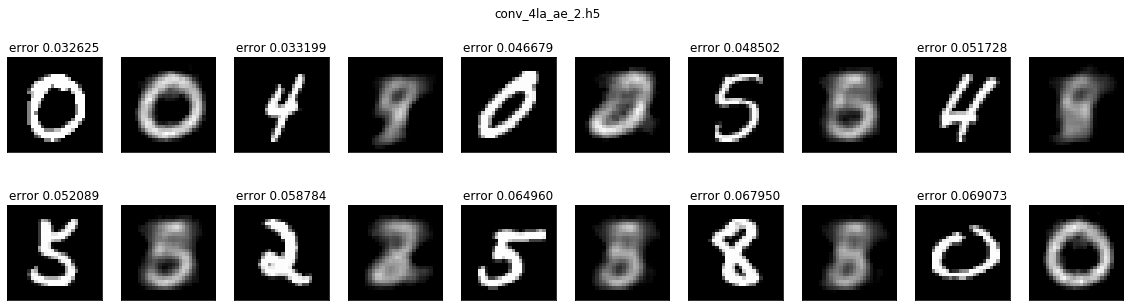

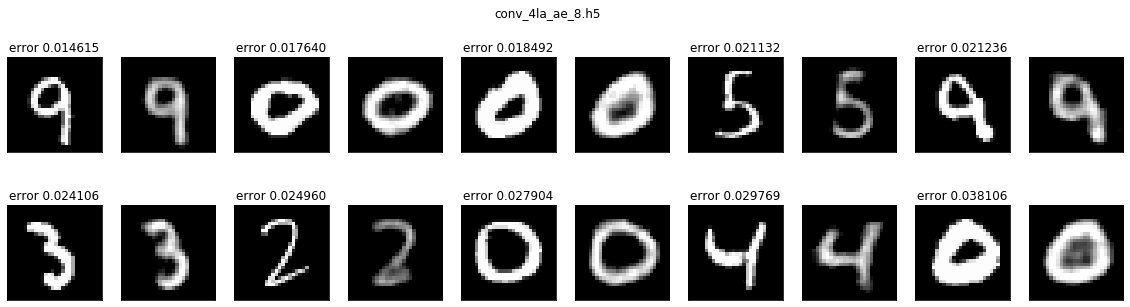

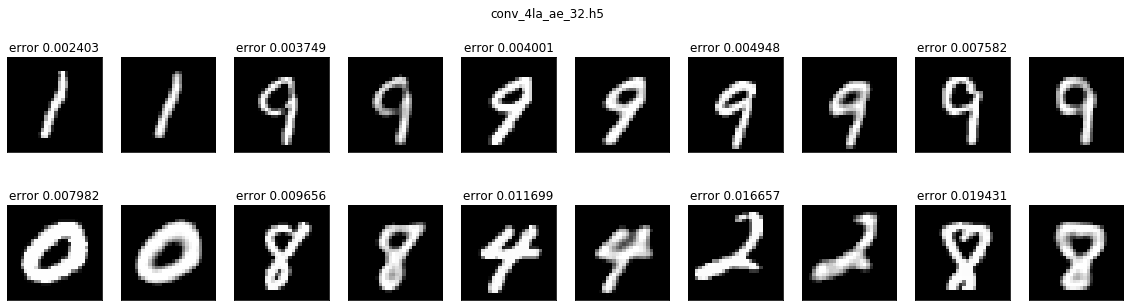

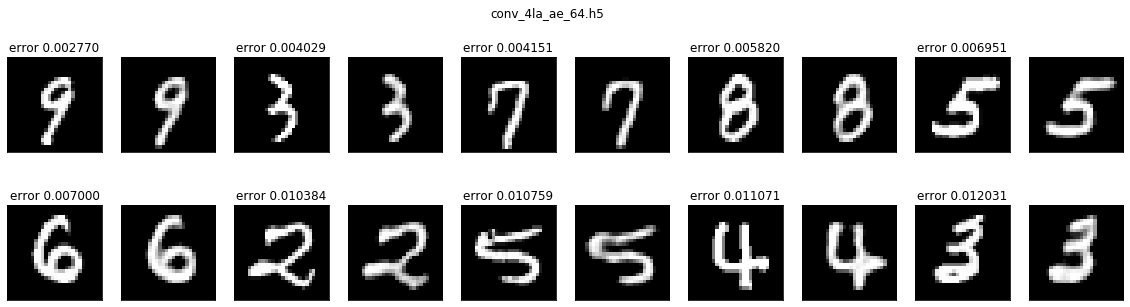

In [17]:
idc = "4la"
for dim in DIMS:
    name = "conv_%s_ae_%d.h5"%(idc,dim)
    ae = keras.models.load_model(name)
    idxs = np.arange(x_test_f.shape[0])
    np.random.shuffle(idxs)
    N = 10
    idxs = idxs[:N]
    reals = x_test[idxs].reshape((len(idxs),28,28,1))
    preds = ae.predict(reals)
    errors = np.mean(np.mean(np.mean((reals-preds)**2,axis=-1),axis=-1),axis=-1)
    # Sort in increasing error
    trf = np.argsort(errors)
    reals = reals[trf]
    preds = preds[trf]
    errors = errors[trf]
    #
    plt.figure(figsize=(2*N,5))
    plt.suptitle(name)
    for i in range(N):
        ax = plt.subplot(2,N,2*i+1)
        ax.set_title("error %f"%errors[i])
        ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
        plt.imshow(reals[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
        ax = plt.subplot(2,N,2*i+2)
        ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
        plt.imshow(preds[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
    plt.show()

> Dado el mucho menor error de reconstrucción y la inspección visual se puede ver que esta representación es mucho mejor para capturar características que permiten reconstruir bien la imagen. Esto muestra la superioridad de las CNN para detectar características significativas en imágenes.

> El patrón de entrada pasa por varios filtros convolucionales para crear varios canales de menor tamaño, cuando se reduce lo suficiente las activaciones se alinean en una dimensión usando *flatten*, luego se usa una capa densa con la cantidad de dimensiones requeridas. Luego se reconstruye la imagen original, primero con un *reshape* y luego con las capas de deconvolución transpuesta.

---

### 2.2 Denoising

Como se ha discutido en clases, un *denoising autoencoder* (dAE)[[4]](#refs) es escencialmente un autoencoder entrenado para reconstruir ejemplos parcialmente corruptos. Varios autores han demostrado que mediante esta modificación simple es posible obtener representaciones más robustas y significativas que aquellas obtenidas por un AE básico. En esta sección exploraremos la aplicación más “natural” o “directa” del método.

---

a) **Genere artificialmente una versión corrupta de las imágenes en MNIST** utilizando el siguiente modelo de ruido (masking noise): si $ x \in {\rm I\!R}^d $ es una de las imágenes originales, la versión ruidosa $\tilde{x}$ se obtiene como $\tilde{x} = x \odot \xi$ donde $\odot$ denota el producto de Hadamard (componente a componente) y $\xi \in {\rm I\!R}^d$ es un vector aleatorio binario con componentes *Ber(p)* independientes.

In [20]:
def noisy(data,p=0.1):
    return data * np.random.binomial(n=1,p=p,size=data.shape)

In [21]:
noisy_x_tra = noisy(x_tra_f)
noisy_x_val = noisy(x_val_f)
noisy_x_test = noisy(x_test_f)

---

b) Entrene un autoencoder para reconstruir las imágenes corruptas generadas en el ı́tem anterior. **Mida el error de reconstrucción y evalúe cualitativamente** (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes. **Experimente diferentes valores de *p* en el rango (0, 1).**

In [22]:
DIMS3 = [16,32]
PVALS = (0.10,0.25,0.50,0.75)

noisy_x_tra = {}
noisy_x_val = {}
noisy_x_test = {}

for p in PVALS:
    noisy_x_tra[p] = noisy(x_tra_f,p)
    noisy_x_val[p] = noisy(x_val_f,p)
    noisy_x_test[p] = noisy(x_test_f,p)

In [ ]:
# ---@> Train models:
for dim in DIMS3:
    for p in PVALS:
        model_ae,model_e,model_d = autoencoder(dim,"relu")
        model_ae.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        model_ae.fit(noisy_x_tra[p],x_tra_f,
                    epochs=REGULAR_EPOCHS,batch_size=REGULAR_BATCH_SIZE,
                    validation_data=(x_val_f,x_val_f))
        model_e.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        model_d.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        #
        ename = "denoi_e_%d_%.3f.h5"%(dim,p)
        dname = "denoi_d_%d_%.3f.h5"%(dim,p)
        name = "denoi_ae_%d_%.3f.h5"%(dim,p)
        model_e.save(ename)
        model_d.save(dname)
        model_ae.save(name)

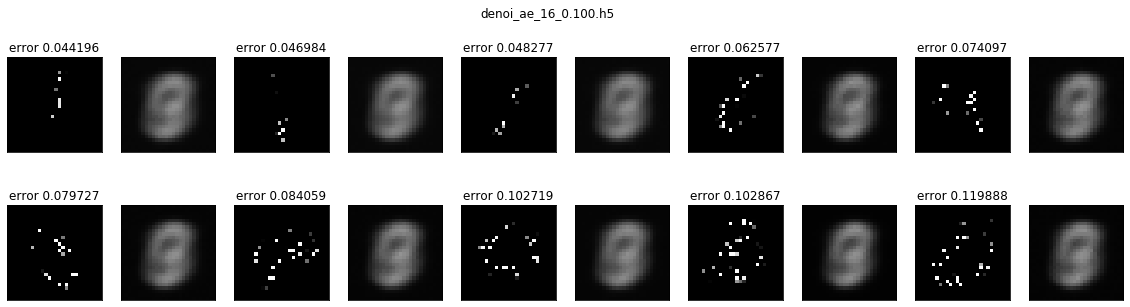

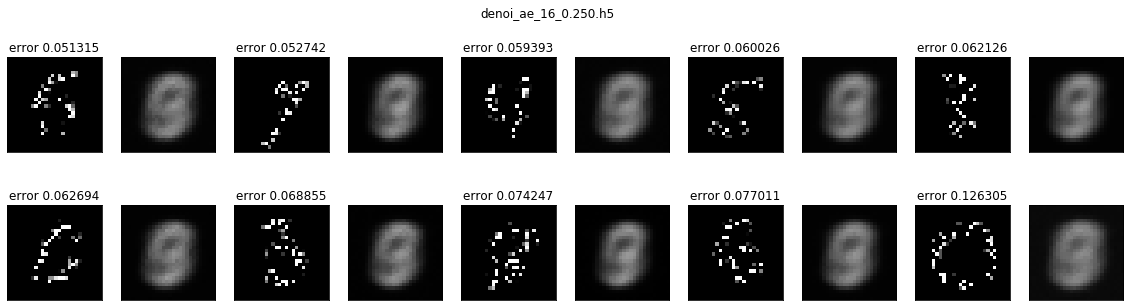

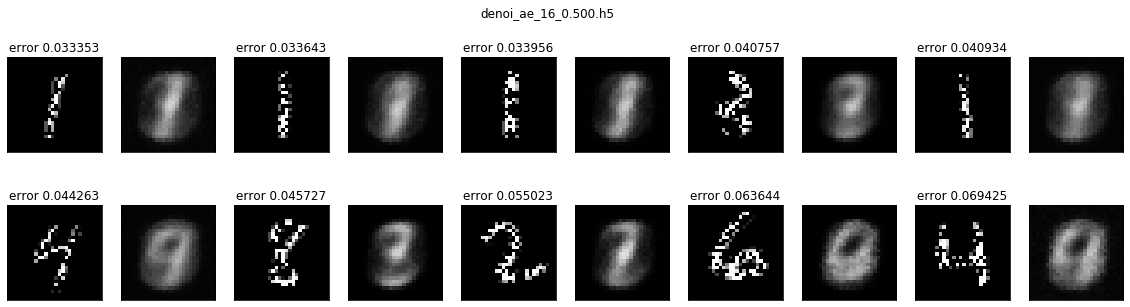

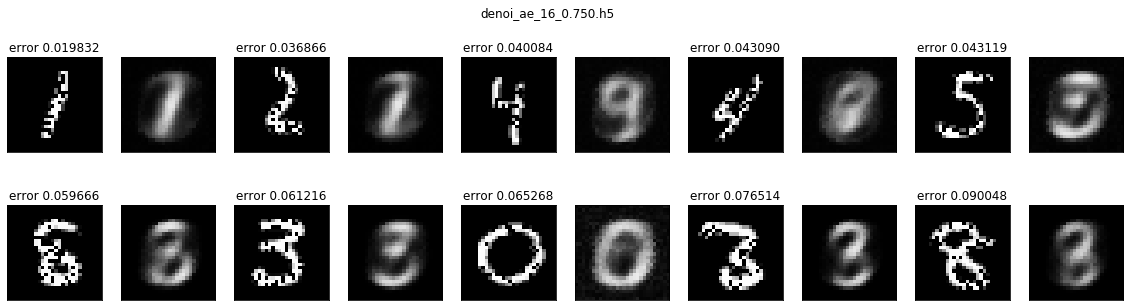

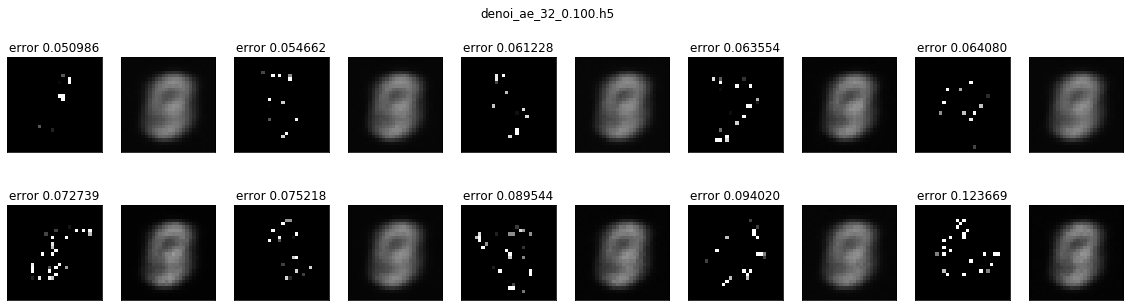

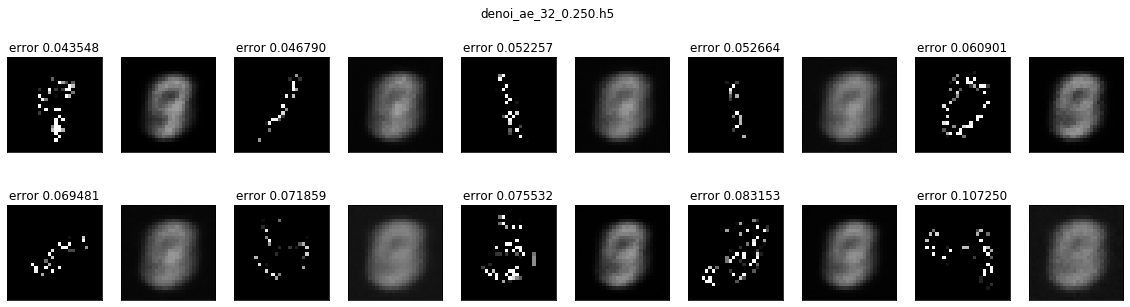

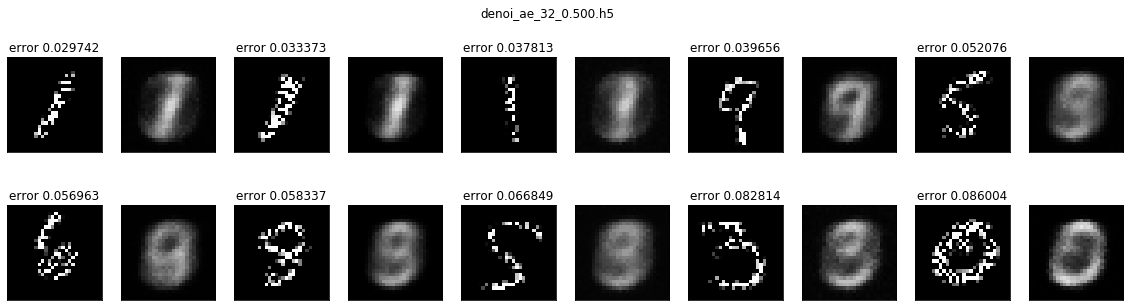

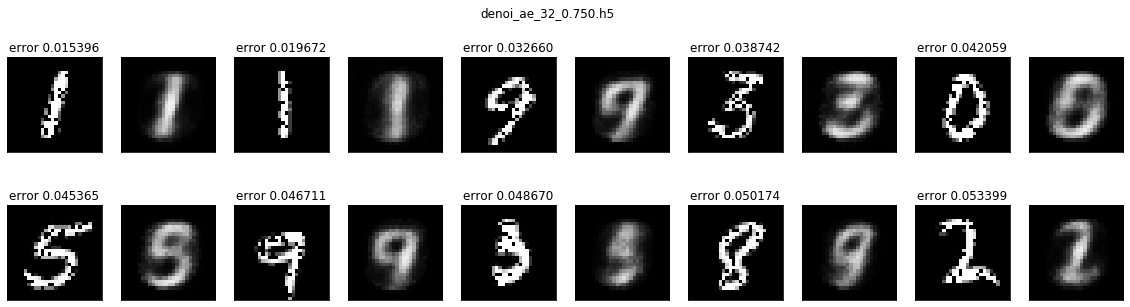

Errors:
	denoi_ae_16_0.100.h5 0.048
	denoi_ae_16_0.250.h5 0.054
	denoi_ae_16_0.500.h5 0.057
	denoi_ae_16_0.750.h5 0.052
	denoi_ae_32_0.100.h5 0.048
	denoi_ae_32_0.250.h5 0.054
	denoi_ae_32_0.500.h5 0.056
	denoi_ae_32_0.750.h5 0.050


In [25]:
total_errors = {}

for dim in DIMS3:
    for p in sorted(list(PVALS)):
        name = "denoi_ae_%d_%.3f.h5"%(dim,p)
        model_ae = keras.models.load_model(name)
        
        noisy_x_test_pred = model_ae.predict(noisy_x_test[p])
        total_error = np.mean((noisy_x_test_pred-noisy_x_test[p])**2)
        total_errors[name] = total_error
        
        idxs = np.arange(noisy_x_test[p].shape[0])
        np.random.shuffle(idxs)
        
        N = 10
        idxs = idxs[:N]
        reals = x_test_f[idxs] # The reals are without noise
        noisy = noisy_x_test[p][idxs]
        preds = model_ae.predict(noisy)
        
        errors = np.mean((reals-preds)**2,axis=1)
        # Sort in increasing error
        trf = np.argsort(errors)
        reals = reals[trf]
        noisy = noisy[trf]
        preds = preds[trf]
        errors = errors[trf]
        #
        plt.figure(figsize=(2*N,5))
        plt.suptitle(name)
        for i in range(N):
            ax = plt.subplot(2,N,2*i+1)
            ax.set_title("error %f"%errors[i])
            ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
            plt.imshow(noisy[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
            ax = plt.subplot(2,N,2*i+2)
            ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
            plt.imshow(preds[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
        plt.show()
print("Errors:")
for name in sorted(list(total_errors.keys())):
    print("\t%-20s %.3f"%(name,total_errors[name]))

> Los errores de reconstrucción de los denoising autoencoders son mucho peores que los de los los AE convencionales, pero se puede ver que estos son capaces de reconstruír el número sin  los errores, siempre que haya pocos píxeles desactivados producto del ruido ($0.750$) y suficientes dimensiones en la representación ($d=32$).

---

c) Utilice la representación reducida, genera por el *denoising AE*, para **medir el desempeño en clasificación** (vı́a kNN como en la sección anterior). Comente.

In [25]:
for dim in DIMS3:
    for p in sorted(list(PVALS)):
        name = "denoi_ae_%d_%.3f.h5"%(dim,p)
        ename = "denoi_e_%d_%.3f.h5"%(dim,p)
        autoenc = keras.models.load_model(name)
        encoder = keras.models.load_model(ename)
        # Reconstruction error
        x_test_pred_f = autoenc.predict(x_test_f,batch_size=REGULAR_BATCH_SIZE)
        recon_error = np.mean(np.mean((x_test_pred_f-x_test_f)**2,axis=1))
        # Clasification error:
        x_tra_enc = encoder.predict(x_tra_f,batch_size=REGULAR_BATCH_SIZE)
        x_test_enc = encoder.predict(x_test_f,batch_size=REGULAR_BATCH_SIZE)
        clf = sklearn.neighbors.KNeighborsClassifier(10)
        clf.fit(x_tra_enc,y_tra)
        score = clf.score(x_test_enc,y_test)
        print("%2ddims %-30s  score:%.3f  recons:%.3f"%(dim,name,score,recon_error))

16dims denoi_ae_16_0.100.h5            score:0.782  recons:0.078
16dims denoi_ae_16_0.250.h5            score:0.789  recons:0.074
16dims denoi_ae_16_0.500.h5            score:0.862  recons:0.054
16dims denoi_ae_16_0.750.h5            score:0.885  recons:0.047
32dims denoi_ae_32_0.100.h5            score:0.880  recons:0.078
32dims denoi_ae_32_0.250.h5            score:0.884  recons:0.070
32dims denoi_ae_32_0.500.h5            score:0.900  recons:0.052
32dims denoi_ae_32_0.750.h5            score:0.921  recons:0.044


> Se puede ver que una gran cantidad de ruido afecta negativamente el score del denoising AE. Aun considerando los casos con $p=0.75$, los scores son peores (aunque por poco) que los obtenidos por los AE regulares:
```
...
32dims ae_relu  score:0.928  recons_tra:0.041  recons_test:0.041
64dims ae_relu  score:0.944  recons_tra:0.037  recons_test:0.037
```

---

d) Diseñe otra manera de generar imágenes corruptas del dataset MNIST, por ejemplo algún tipo de ruido, sea creativo. **Mida el error de reconstrucción y evalúe cualitativamente** (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes.

In [27]:
@numba.jit
def creepy_noise(data,t=50):
    data = np.copy(data).reshape((data.shape[0],28,28))
    for i in range(data.shape[0]):
        for _ in range(t):
            d = random.randint(0,3)
            pos = random.randint(0,27)
            if d==0:
                data[i,pos,:-1] = np.copy(data[i,pos,1:])
            elif d==1:
                data[i,pos,1:] = np.copy(data[i,pos,:-1])
            elif d==2:
                data[i,:-1,pos] = np.copy(data[i,1:,pos])
            elif d==3:
                data[i,1:,pos] = np.copy(data[i,:-1,pos])
    return data.reshape((data.shape[0],28*28))

In [28]:
creepy_x_tra = creepy_noise(x_tra_f)
creepy_x_val = creepy_noise(x_val_f)
creepy_x_test = creepy_noise(x_test_f)

In [29]:
DIM = 32

In [ ]:
# ---@> Train model:
model_ae,model_e,model_d = autoencoder(dim,"relu")
model_ae.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
model_ae.fit(creepy_x_tra,x_tra_f,
            epochs=REGULAR_EPOCHS,batch_size=REGULAR_BATCH_SIZE,
            validation_data=(x_val_f,x_val_f))
model_e.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
model_d.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
#
ename = "creepy_e_%d.h5"%(dim)
dname = "creepy_d_%d.h5"%(dim)
name = "creepy_ae_%d.h5"%(dim)
model_e.save(ename)
model_d.save(dname)
model_ae.save(name)

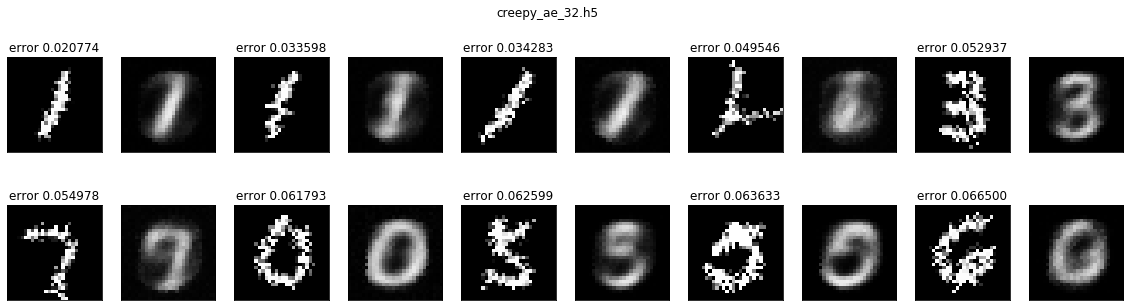

Error:
	creepy_ae_32.h5      0.054


In [31]:
# Load model from the last cell
name = "creepy_ae_%d.h5"%(DIM)
model_ae = keras.models.load_model(name)

creepy_x_test_pred = model_ae.predict(creepy_x_test)
total_error = np.mean((creepy_x_test_pred-creepy_x_test)**2)

idxs = np.arange(creepy_x_test.shape[0])
np.random.shuffle(idxs)

N = 10
idxs = idxs[:N]
reals = creepy_x_test[idxs]
preds = model_ae.predict(reals)

errors = np.mean((reals-preds)**2,axis=1)
# Sort in increasing error
trf = np.argsort(errors)
reals = reals[trf]
preds = preds[trf]
errors = errors[trf]
#
plt.figure(figsize=(2*N,5))
plt.suptitle(name)
for i in range(N):
    ax = plt.subplot(2,N,2*i+1)
    ax.set_title("error %f"%errors[i])
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    plt.imshow(reals[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
    ax = plt.subplot(2,N,2*i+2)
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    plt.imshow(preds[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
plt.show()

print("Error:")
print("\t%-20s %.3f"%(name,total_error))

> Para esta parte se ideó el "creepy noise*, que consiste en elegir al azar una columna o fila de la imagen y correr los píxeles hacia arriba o abajo, o izquierda o derecha, respectivamente. Esto se repetive 50 veces. Para acelerarlo se utilizó el decorador `@jit` de `numba`.

> Aun así se obtiene un error de reconstrucción mayor que con el ruido anterior, es posible que se deba a que el ruido inventado para esta tarea está muy alejado de la verdadera forma en que varían las muestras.

---

### 2.3 *Similarity reconstruct*

En esta sección se explorará una forma diferente de implementar un *autoencoder* que es utilizar la arquitectura del *autoencoder* pero no para reconstruir el mismo dato, sino que para reconstruir un dato similar. En este caso la similaridad estará dada por las clases de los datos.

---

a) Genere pares de objetos $(objeto,similar)$ con 10 datos similares al dato "objeto", para ésto utilice la función que se provee a continuación sobre los primeros (1000 a 2000) datos de entrenamiento. **Visualice los nuevos datos generados y la relación que se produce entre los pares de objetos**.

In [31]:
def similarity_data(X,Y,sim=10):
    index_classes = [np.where(Y==number)[0] for number in range(10)]
    new_X = []
    simi_X = []
    for x,y in zip(X,Y):
        similarities = index_classes[y]
        sample_sim = np.random.choice(similarities,sim)
        new_X.append(np.tile(x,(sim,1)))
        simi_X.append(X[sample_sim])    
    new_X = np.concatenate(new_X,axis=0)
    simi_X = np.concatenate(simi_X,axis=0)
    return new_X,simi_X

data.shape (55000, 784)
data_sim.shape (55000, 784)


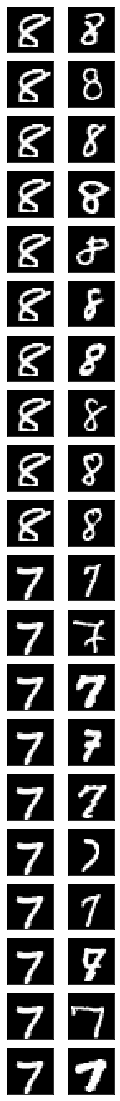

In [32]:
data,data_sim = similarity_data(x_tra_f[:5500],y_tra[:5500])

print("data.shape",data.shape)
print("data_sim.shape",data_sim.shape)

#
N = 20
plt.figure(figsize=(2,N))
#plt.suptitle(name)
for i in range(N):
    ax = plt.subplot(N,2,2*i+1)
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    plt.imshow(data[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
    ax = plt.subplot(N,2,2*i+2)
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    plt.imshow(data_sim[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
plt.show()

> Cada imagen es pareada con otra de la misma clase (número correspondiente).

---

b) Escoja algunas de las arquitecturas ya experimentadas hasta este punto de la actividad y entrénela para enfrentarla a éste problema **¿La función de pérdida se mantiene?**

In [33]:
DIM5 = 16

In [ ]:
# ---@> Train models:
dae1,enc1,_ = deep_autoencoder(DIM5,nneurons=(1000,500,250))
dae1.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
dae1.fit(x_tra_f,x_tra_f,epochs=REGULAR_EPOCHS,
        batch_size=REGULAR_BATCH_SIZE,
        validation_data=(x_val_f,x_val_f))
name = "deep_%s_ae_%d.h5"%("regular",DIM5)
dae1.save(name)
enc1.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
name = "deep_%s_e_%d.h5"%("regular",DIM5)
enc1.save(name)

dae2,enc2,_ = deep_autoencoder(DIM5,nneurons=(1000,500,250))
dae2.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
dae2.fit(data,data_sim,epochs=REGULAR_EPOCHS,
        batch_size=REGULAR_BATCH_SIZE,
        validation_data=(x_val_f,x_val_f))
name = "deep_%s_ae_%d.h5"%("similarity",DIM5)
dae2.save(name)
enc2.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
name = "deep_%s_e_%d.h5"%("similarity",DIM5)
enc2.save(name)

In [35]:
for kind in ("regular","similarity"):
    name = "deep_%s_ae_%d.h5"%(kind,DIM5)
    model_ae = keras.models.load_model(name)

    x_test_pred = model_ae.predict(creepy_x_test)
    total_error = np.mean((x_test_pred-x_test_f)**2)
    print("Error:")
    print("\t%-30s %.3f"%(name,total_error))

Error:
	deep_regular_ae_16.h5          0.037
Error:
	deep_similarity_ae_16.h5       0.055


> Se puede ver que la pérdida aumenta para el mismo número de dimensiones (16) respecto a un AE regular en la tarea de reconstrucción de la imagen original. Sin embargo, esto se puede deber a que se logró un aprendizaje más relacionado con generar la clase correcta que la imagen original, como se ve en el siguiente ítem.

---

c) **Visualice lo que genera el *autoencoder* dado una imagen de entrada**. Además **visualice, con la herramienta TSNE, los *embedding*/representación reducida** que se producen en el *encoder*.

deep_similarity_ae_16.h5


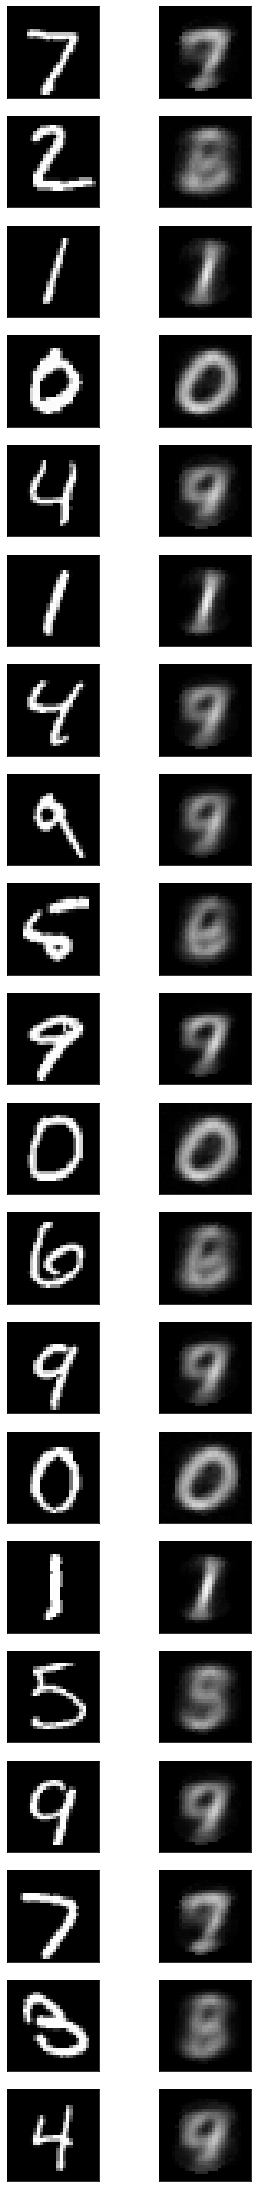

In [35]:
name = "deep_%s_ae_%d.h5"%("similarity",DIM5)
autoenc = keras.models.load_model(name)

N = 20
preds = autoenc.predict(x_test_f[:N])
plt.figure(figsize=(5,2*N))
print(name)
for i in range(N):
    ax = plt.subplot(N,2,2*i+1)
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    plt.imshow(x_test_f[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
    ax = plt.subplot(N,2,2*i+2)
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    plt.imshow(preds[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
plt.show()

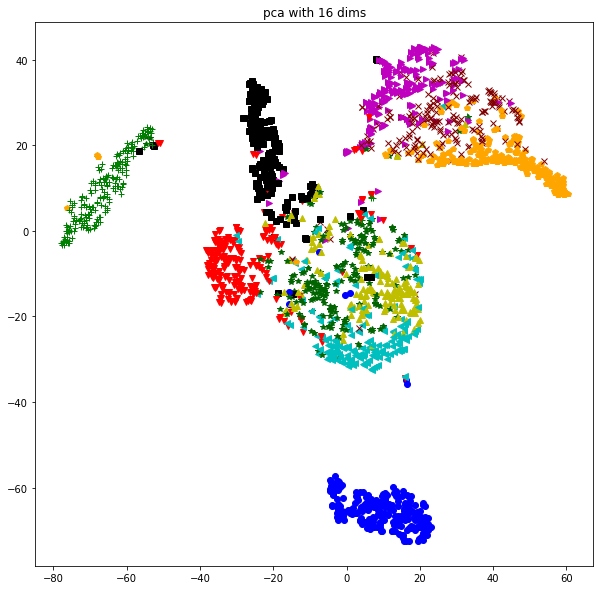

In [36]:
name = "deep_%s_e_%d.h5"%("similarity",DIM5)
encoder = keras.models.load_model(name)

nplot = 2000
enc_tra = encoder.predict(x_tra_f[:nplot])

model = sklearn.manifold.TSNE(n_components=2,random_state=0)
enc_tra = model.fit_transform(enc_tra)

# Plot with tnse:
plt.figure(figsize=(10,10))
plt.title(("autoencoder" if t==0 else "pca")+" with %d dims"%dims)
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(nplot):
    label = y_tra[idx]
    line = plt.plot(enc_tra[idx][0],enc_tra[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
plt.show()

> Como es de esperar, las imágenes generadas corresponden aparentemente a un promedio de las imagenes de la clase correcta más que una reconstrucción de la original.

> Se puede ver que "similarity AE" separa algunas clases más claramente que las representaciones AE, sin embargo, existe un alto grado de superposición en otras clases más similares.

---

### 2.4 Pre-*training*

En esta sección utilizaremos un AE para pre-entrenar redes profundas. Como hemos discutido en clases, el efecto esperado es regularizar el modelo, posicionando el modelo de partida en una buena zona del espacio de parámetros.

---

a) Construya y entrene una red FF para clasificar las imágenes de MNIST. Utilice SGD básico con tasa de aprendizaje fija $\eta = 0.01$, momentum $m=0.9$ y no más de 50 *epochs*. Para empezar, utilice una arquitectura $768 \times 1000 \times 1000 \times 10$ y **funciones de activación sigmoidales**. **Determine error de clasificación alcanzado por el modelo en el conjunto de test.**

In [38]:
y_tra_c = keras.utils.to_categorical(y_tra, 10)
y_val_c = keras.utils.to_categorical(y_val, 10)
y_test_c = keras.utils.to_categorical(y_test, 10)

In [37]:
def save_dict(dic,fname):
    f = open(fname,'w')
    f.write(str(dic))
    f.close()

def load_dict(fname):
    f = open(fname,'r')
    data = f.read()
    f.close()
    return eval(data)

def plot_errors(data,accuracy=True,name=None):
    labels = sorted([x for x in data])
    loss_labs = [x for x in labels if 'loss' in x]
    acc_labs = [x for x in labels if 'acc' in x]
    n_points = np.max([len(data[la]) for la in labels])
    # Create subplots
    if accuracy:
        fig, (ax1, ax2) = plt.subplots(1,2,sharex=True,figsize=(12,6))
    else:
        fig, ax1 = plt.subplots(1,1,sharex=True,figsize=(12,6))
    fig.suptitle("Metrics v/s epochs"+("" if name is None else " for %s"%name))
    #
    for lab in loss_labs:
        ax1.plot(1+np.arange(n_points),data[lab],label=lab)
    ax1.legend(loc="upper right")
    ax1.set_title("loss")
    ax1.grid(True)
    #
    if accuracy:
        for lab in acc_labs:
            ax2.plot(1+np.arange(n_points),data[lab],label=lab)
        ax2.set_ylim((0,1.0))
        ax2.legend(loc="lower right")
        ax2.set_title("accuracy")
        ax2.grid(True)
    #
    plt.show()

In [39]:
def pretrainable_ffw(activ='sigmoid'):
    input_layer = keras.layers.Input(shape=x_tra_f.shape[1:])
    front = input_layer
    #
    front = keras.layers.Dense(1000, activation=activ)(front)
    ae1_output = keras.layers.Dense(x_tra_f.shape[1])(front)
    ae1 = keras.models.Model(inputs=input_layer,outputs=ae1_output)
    #
    front = keras.layers.Dense(1000, activation=activ)(front)
    ae2_output = keras.layers.Dense(x_tra_f.shape[1])(front)
    ae2 = keras.models.Model(inputs=input_layer,outputs=ae2_output)
    #
    front = keras.layers.Dense(10,activation='softmax')(front)
    ffw = keras.models.Model(inputs=input_layer,outputs=front)
    #
    return ae1,ae2,ffw

In [40]:
ae1,ae2,ffw = pretrainable_ffw()
print("\nAutoencoder 1:")
ae1.summary()
print("\nAutoencoder 2:")
ae2.summary()
print("\nFeed Forward:")
ffw.summary()


Autoencoder 1:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_125 (Dense)            (None, 1000)              785000    
_________________________________________________________________
dense_126 (Dense)            (None, 784)               784784    
Total params: 1,569,784
Trainable params: 1,569,784
Non-trainable params: 0
_________________________________________________________________

Autoencoder 2:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_125 (Dense)            (None, 1000)              785000    
__________________________________

In [ ]:
# ---@> Train model:
_,_,ffw = pretrainable_ffw()
optimizer_ = keras.optimizers.SGD(lr=0.01, momentum=0.9)
#
ffw.compile(optimizer=optimizer_,loss='categorical_crossentropy',metrics=['accuracy'])
history_ffw = ffw.fit(x_tra_f,y_tra_c,epochs=PRETRAIN_EPOCHS,
          batch_size=REGULAR_BATCH_SIZE,shuffle=True,
          validation_data=(x_val_f,y_val_c))
#
save_dict(history_ffw.history,'ffw_end2end_history.txt')
ffw.save('ffw_end2end.h5')

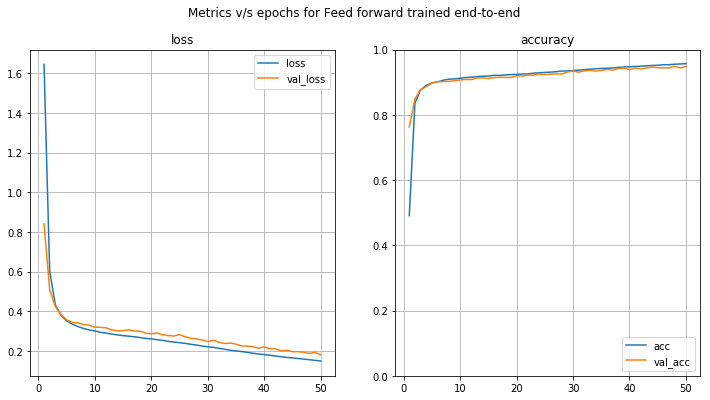

Final validation loss:      0.18148320864140988
Final validation accuracy:  0.9486
10000/10000 [==============================] - 1s 115us/step
Final test loss:            0.15884395046159624
Final test accuracy:        0.9542


In [45]:
hist = load_dict('ffw_end2end_history.txt')
plot_errors(hist,name="Feed forward trained end-to-end",accuracy=True)
print("Final validation loss:     ",hist['val_loss'][-1])
print("Final validation accuracy: ",hist['val_acc'][-1])

ffw_model = keras.models.load_model("ffw_end2end.h5")
evalu = ffw_model.evaluate(x_test_f,y_test_c)
print("Final test loss:           ",evalu[0])
print("Final test accuracy:       ",evalu[1])

> Se puede ver que el error de accuracy alcanzado en el conjunto de validación y el de testing fue de alrededor del 5%.

---

b) Construya y entrene una red neuronal profunda para clasificar las imágenes de MNIST utilizando la arquitectura propuesta en (a) y pre-entrenando los pesos de cada capa mediante un autoencoder básico. Proceda en modo clásico, es decir, entrenando en modo no supervisado una capa a la vez y tomando como input de cada nivel la representación (entrenada) obtenida en el nivel anterior. Después del entrenamiento efectúe un entrenamiento supervisado convencional (*fine-tunning*). **Compare los resultados de clasificación sobre el conjunto de pruebas con aquellos obtenidos en (a), sin pre-entrenamiento. Evalúe también los resultados antes del *fine-tunning*.** Comente.
<!--
```python
from keras.datasets import mnist
... ## Load and preprocess MNIST as usual
...###AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1,activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(inputs=input_img1, outputs=decoded1)
encoder1 = Model(inputs=input_img1, outputs=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(x_train, x_train, nb_epoch=epochs_, batch_size=batch_size_,shuffle=True, validation_data=(x_val, x_val))
encoded_input1 = Input(shape=(n_hidden_layer1,))
autoencoder1.save('autoencoder_layer1.h5')
encoder1.save('encoder_layer1.h5')
...###AUTOENCODER 2
x_train_encoded1 = encoder1.predict(x_train) #FORWARD PASS DATA THROUGH FIRST ENCODER
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)
input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer2, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(inputs=input_img2, outputs=decoded2)
encoder2 = Model(inputs=input_img2, outputs=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(x_train_encoded1,x_train_encoded1,nb_epoch=epochs_,batch_size=batch_size_,shuffle=True, validation_data=(x_val_encoded1, x_val_encoded1))
encoded_input2 = Input(shape=(n_hidden_layer2,))
autoencoder2.save('autoencoder_layer2.h5')
encoder2.save('encoder_layer2.h5')
...#FINE TUNNING
from keras.models import Sequential
model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.layers[-1].set_weights(autoencoder2.layers[1].get_weights())
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer=optimizer_,loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train,nb_epoch=20, batch_size=25,
shuffle=True, validation_data=(x_val, Y_val))
model.save('Net-768x1000x1000x10-finetunned.h5')
```
-->

In [ ]:
# ---@> Train models:
ae1,ae2,ffw = pretrainable_ffw()
optimizer_ = keras.optimizers.SGD(lr=0.01, momentum=0.9)
#
ae1.compile(optimizer=optimizer_,loss='mse')
history_ae1 = ae1.fit(x_tra_f,x_tra_f,epochs=PRETRAIN_EPOCHS,
          batch_size=REGULAR_BATCH_SIZE,shuffle=True,
          validation_data=(x_val_f,x_val_f))
save_dict(history_ae1.history,'ffw_pretrain_ae1_history.txt')
ae1.save('ffw_pretrain_ae1.h5')
#
ae2.compile(optimizer=optimizer_,loss='mse')
history_ae2 = ae2.fit(x_tra_f,x_tra_f,epochs=PRETRAIN_EPOCHS,
          batch_size=REGULAR_BATCH_SIZE,shuffle=True,
          validation_data=(x_val_f,x_val_f))
save_dict(history_ae2.history,'ffw_pretrain_ae2_history.txt')
ae2.save('ffw_pretrain_ae2.h5')
#
ffw.compile(optimizer=optimizer_,loss='categorical_crossentropy',metrics=['accuracy'])
ffw.save('ffw_pretrain_ffw_before.h5')
history_ffw = ffw.fit(x_tra_f,y_tra_c,epochs=PRETRAIN_EPOCHS,
          batch_size=REGULAR_BATCH_SIZE,shuffle=True,
          validation_data=(x_val_f,y_val_c))
save_dict(history_ffw.history,'ffw_pretrain_ffw_history.txt')
ffw.save('ffw_pretrain_ffw.h5')

In [44]:
ffw_before = keras.models.load_model('ffw_pretrain_ffw_before.h5')
loss = ffw_before.evaluate(x_test_f,y_test_c)
print("Accuracy before fine-tunning: %.4f"%loss[1])
ffw = keras.models.load_model('ffw_pretrain_ffw.h5')
loss = ffw.evaluate(x_test_f,y_test_c)
print("Accuracy after fine-tunning: %.4f"%loss[1])

/home/fcasas/Music/p36env/lib/python3.6/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


10000/10000 [==============================] - 2s 171us/step
Accuracy before fine-tunning: 0.0982
10000/10000 [==============================] - 2s 169us/step
Accuracy after fine-tunning: 0.9584


> Claramente el error después del fine-tunning disminuyó considerablemente, dado que de otra manera la capa final no está entrenada para resolver la tarea.

> Las comparaciones con (a) se realizan junto con las del ítem siguiente.

---

c) Repita usando funciones de **activación *tanh*. Comente**

In [ ]:
# ---@> Train models:
ae1,ae2,ffw = pretrainable_ffw(activ='tanh')
optimizer_ = keras.optimizers.SGD(lr=0.01, momentum=0.9)
#
ae1.compile(optimizer=optimizer_,loss='mse')
history_ae1 = ae1.fit(x_tra_f,x_tra_f,epochs=PRETRAIN_EPOCHS,
          batch_size=REGULAR_BATCH_SIZE,shuffle=True,
          validation_data=(x_val_f,x_val_f))
save_dict(history_ae1.history,'ffw_tanh_pretrain_ae1_history.txt')
ae1.save('ffw_tanh_pretrain_ae1.h5')
#
ae2.compile(optimizer=optimizer_,loss='mse')
history_ae2 = ae2.fit(x_tra_f,x_tra_f,epochs=PRETRAIN_EPOCHS,
          batch_size=REGULAR_BATCH_SIZE,shuffle=True,
          validation_data=(x_val_f,x_val_f))
save_dict(history_ae2.history,'ffw_tanh_pretrain_ae2_history.txt')
ae2.save('ffw_tanh_pretrain_ae2.h5')
#
ffw.compile(optimizer=optimizer_,loss='categorical_crossentropy',metrics=['accuracy'])
ffw.save('ffw_tanh_pretrain_ffw_before.h5')
history_ffw = ffw.fit(x_tra_f,y_tra_c,epochs=PRETRAIN_EPOCHS,
          batch_size=REGULAR_BATCH_SIZE,shuffle=True,
          validation_data=(x_val_f,y_val_c))
save_dict(history_ffw.history,'ffw_tanh_pretrain_ffw_history.txt')
ffw.save('ffw_tanh_pretrain_ffw.h5')

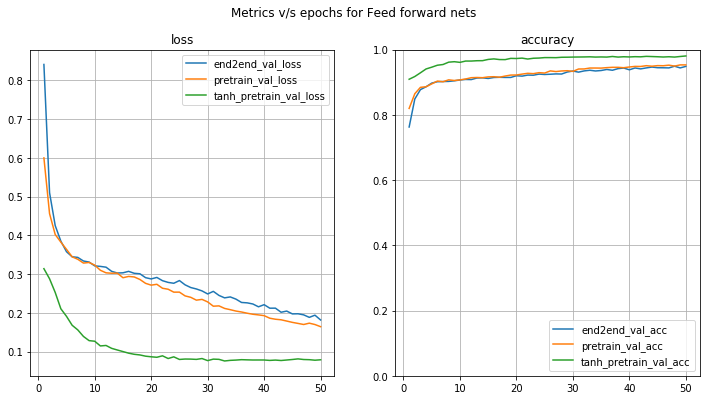

In [46]:
hist1 = load_dict('ffw_end2end_history.txt')
hist2 = load_dict('ffw_pretrain_ffw_history.txt')
hist3 = load_dict('ffw_tanh_pretrain_ffw_history.txt')

dict1 = {'end2end_'+key: hist1[key] for key in hist1 if 'val' in key}
dict2 = {'pretrain_'+key: hist2[key] for key in hist2 if 'val' in key}
dict3 = {'tanh_pretrain_'+key: hist3[key] for key in hist3 if 'val' in key}
dicti = dict1.copy()
dicti.update(dict2)
dicti.update(dict3)

plot_errors(dicti,name="Feed forward nets",accuracy=True)

In [47]:
ffw_before = keras.models.load_model('ffw_tanh_pretrain_ffw_before.h5')
loss = ffw_before.evaluate(x_test_f,y_test_c)
print("Accuracy before fine-tunning: %.4f"%loss[1])
ffw = keras.models.load_model('ffw_tanh_pretrain_ffw.h5')
loss = ffw.evaluate(x_test_f,y_test_c)
print("Accuracy after fine-tunning: %.4f"%loss[1])

/home/fcasas/Music/p36env/lib/python3.6/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


10000/10000 [==============================] - 2s 173us/step
Accuracy before fine-tunning: 0.1125
10000/10000 [==============================] - 2s 175us/step
Accuracy after fine-tunning: 0.9800


> Se puede ver que la red pre-entrenada logró disminuír el error más rápidamente en la primera epoch y finalmente logró una accuracy ligeramente mejor. La red con activaciones *tanh* en vez de *sigmoids* logró un desempeño mucho mejor que las anteriores y un aprendizaje mucho más rápido, lo que se puede haber debido a la capacidad de representar activaciones con diferente signo, y por lo tanto pre-entrenar pesos que consideran este tipo de entrada.  

---

<a id="refs"></a>
## Referencias
[1] George Kingsley Zipf (1949), *Human behavior and the principle of least effort*, Addison-Wesley Press  
[2] https://www.nvidia.es/object/cuda-parallel-computing-es.html  
[3] http://yann.lecun.com/exdb/mnist/  
[4] Vincent, P., Larochelle, H., Bengio, Y., & Manzagol, P. A. (2008, July). *Extracting and composing robust features with denoising autoencoders*. ACM.